# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [85]:
# import libraries
import torch
import numpy as np

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

True
Using device: cuda


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [86]:

from torch.utils.data import Dataset, DataLoader

# from torchvision import datasets
import torchvision.transforms as transforms
import scipy

EXP_CONFIG = 0 # 0,1
# how many samples per batch to load
BATCH_SIZE = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

class CustomTrainImageDataset(Dataset):

    mat_data_file = "./digits4000.mat"

    def __init__(self, config: int = EXP_CONFIG):
        data_matrix = scipy.io.loadmat(self.mat_data_file)
        self.config = config
        self.img_labels:np.ndarray = data_matrix.get("digits_labels")
        self.img_vectors:np.ndarray = data_matrix.get("digits_vec")
        self.trainset:np.ndarray = data_matrix.get("trainset")
        self.testset:np.ndarray = data_matrix.get("testset")

        self.transform = transform

    def __len__(self):
        return len(self.trainset[EXP_CONFIG])

    def __getitem__(self, idx):
        if self.config == 0:
            image_id = self.trainset[0, idx] - 1
        elif self.config == 1:
            image_id = self.trainset[1, idx] - 1
        
        label = self.img_labels[0, image_id]
        image = self.img_vectors[:, image_id].reshape((28, 28))

        if self.transform:
            image = self.transform(image)
        return image, label
    
class CustomTestImageDataset(Dataset):

    mat_data_file = "./digits4000.mat"

    def __init__(self, config: int = EXP_CONFIG):
        data_matrix = scipy.io.loadmat(self.mat_data_file)
        self.config = config
        self.img_labels:np.ndarray = data_matrix.get("digits_labels")
        self.img_vectors:np.ndarray = data_matrix.get("digits_vec")
        self.trainset:np.ndarray = data_matrix.get("trainset")
        self.testset:np.ndarray = data_matrix.get("testset")

        self.transform = transform

    def __len__(self):
        return len(self.testset[EXP_CONFIG])

    def __getitem__(self, idx):
        if self.config == 0:
            image_id = self.testset[0, idx] - 1
        elif self.config == 1:
            image_id = self.testset[1, idx] - 1
        
        label = self.img_labels[0, image_id]
        image = self.img_vectors[:, image_id].reshape((28, 28))

        if self.transform:
            image = self.transform(image)
        return image, label



### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_data(train_dataloader: DataLoader):
    # obtain one batch of training images
    images, labels = next(iter(train_dataloader))
    images = images.numpy()

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(BATCH_SIZE):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    
    img = np.squeeze(images[1])
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [88]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [89]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [90]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

def train(train_dataloader: DataLoader):
    model.train() # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            
        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [91]:
# initialize lists to monitor test loss and accuracy


def eval(test_dataloader: DataLoader):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval() # prep model for *evaluation*

    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(BATCH_SIZE):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

In [92]:
def visualize_results(test_dataloader: DataLoader):
    # obtain one batch of test images
    images, labels = next(iter(test_dataloader))
    images = images.to(device)

    # get sample outputs
    output = model(images)
    output.cpu()
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(BATCH_SIZE):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"))

## Results

### CONFIG 0

Epoch: 1 	Training Loss: 4.657967
Epoch: 2 	Training Loss: 2.162078
Epoch: 3 	Training Loss: 1.385794
Epoch: 4 	Training Loss: 1.082888
Epoch: 5 	Training Loss: 0.920236
Epoch: 6 	Training Loss: 0.817735
Epoch: 7 	Training Loss: 0.745772
Epoch: 8 	Training Loss: 0.691411
Epoch: 9 	Training Loss: 0.649415
Epoch: 10 	Training Loss: 0.615073
Epoch: 11 	Training Loss: 0.586672
Epoch: 12 	Training Loss: 0.561962
Epoch: 13 	Training Loss: 0.541428
Epoch: 14 	Training Loss: 0.523375
Epoch: 15 	Training Loss: 0.507531
Epoch: 16 	Training Loss: 0.492464
Epoch: 17 	Training Loss: 0.480167
Epoch: 18 	Training Loss: 0.468489
Epoch: 19 	Training Loss: 0.457949
Epoch: 20 	Training Loss: 0.448056
Epoch: 21 	Training Loss: 0.438915
Epoch: 22 	Training Loss: 0.430754
Epoch: 23 	Training Loss: 0.422945
Epoch: 24 	Training Loss: 0.415425
Epoch: 25 	Training Loss: 0.408936
Epoch: 26 	Training Loss: 0.402475
Epoch: 27 	Training Loss: 0.396639
Epoch: 28 	Training Loss: 0.390908
Epoch: 29 	Training Loss: 0.3

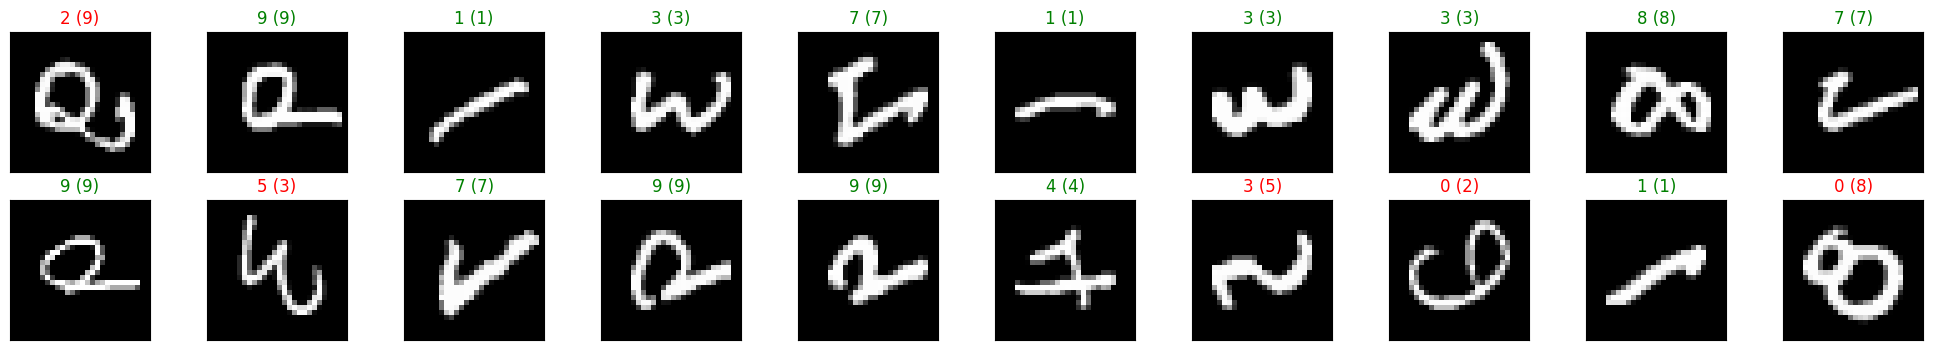

In [93]:
# prepare datasets
train_dataset = CustomTrainImageDataset(config=0)
test_dateset = CustomTestImageDataset(config=0)

# prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dateset, batch_size=BATCH_SIZE, shuffle=True)

train(train_dataloader)
eval(test_dataloader)
visualize_results(test_dataloader)

### CONFIG 1

Epoch: 1 	Training Loss: 0.434416
Epoch: 2 	Training Loss: 0.423516
Epoch: 3 	Training Loss: 0.415005
Epoch: 4 	Training Loss: 0.406891
Epoch: 5 	Training Loss: 0.400051
Epoch: 6 	Training Loss: 0.393506
Epoch: 7 	Training Loss: 0.387285
Epoch: 8 	Training Loss: 0.381501
Epoch: 9 	Training Loss: 0.376349
Epoch: 10 	Training Loss: 0.371185
Epoch: 11 	Training Loss: 0.366373
Epoch: 12 	Training Loss: 0.361872
Epoch: 13 	Training Loss: 0.357514
Epoch: 14 	Training Loss: 0.353524
Epoch: 15 	Training Loss: 0.349430
Epoch: 16 	Training Loss: 0.345441
Epoch: 17 	Training Loss: 0.341958
Epoch: 18 	Training Loss: 0.338139
Epoch: 19 	Training Loss: 0.335003
Epoch: 20 	Training Loss: 0.331691
Epoch: 21 	Training Loss: 0.328600
Epoch: 22 	Training Loss: 0.325429
Epoch: 23 	Training Loss: 0.322524
Epoch: 24 	Training Loss: 0.319581
Epoch: 25 	Training Loss: 0.316815
Epoch: 26 	Training Loss: 0.314306
Epoch: 27 	Training Loss: 0.311736
Epoch: 28 	Training Loss: 0.308828
Epoch: 29 	Training Loss: 0.3

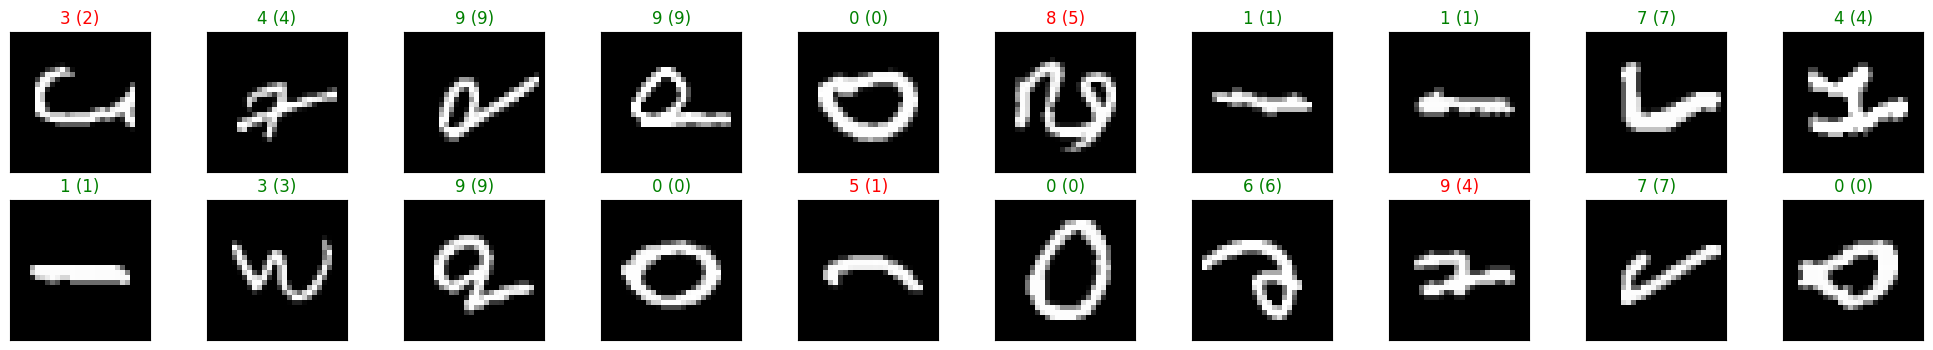

In [94]:
# prepare datasets
train_dataset = CustomTrainImageDataset(config=1)
test_dateset = CustomTestImageDataset(config=1)

# prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dateset, batch_size=BATCH_SIZE, shuffle=True)

train(train_dataloader)
eval(test_dataloader)
visualize_results(test_dataloader)